# N-Step Bootstraping(2023)

An implementation of a n-step bootstrapping method(Sutton and Barto's 2nd edition chapter 7) version 2023(I had already implemented this years ago but using a simple grid-world) using the Mountain Car environment and function approximation(using regression for approximating the value function with sklearn's SGDRegressor)

N-step bootstrapping is based on the following intuition: neither one-step TD nor Monte Carlo methods are always the best, the original bellman value equation is recursive and is based on a reward plus proportional value of the next state which is an approximation, but the reward is an exact observation from the MDP so it's completely reliable, if the reward is the accurate part of the calculation, why not use 2 or more rewards instead of only 1?  We can use n rewards and then the approximation of the value n steps later.

n-step bootstrapping unifies one-step temporal difference methods(like sarsa or q learning) with Monte Carlo methods and introduces a tradeoff between these:
* 1-step bootstrapping is the usual TD methods.
* T-step methods is Monte Carlo

n-step bootstrapping is an important component of a powerful idea: elegibility traces which enables bootstrapping over multiple n-step approximations simultaneously.

In [15]:
import gym
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

## Preprocessing and feature eng.

In this section all functions related to processing the data(an calculating features are created)

In [2]:
class FeatureTransformer:
    """Performs the rbf feature calculator for the states"""
    def __init__(self,env:gym.Env,sample_size,rbf_components):
        """
            env: the openAI gym environment
            sample_size: number of random samples from the state space to create the RBF features
            rbf_components: the number of rbf components used for every variance
        """
        state_samples = np.array([env.observation_space.sample() for _ in range(sample_size)]) # used to train the RBF monte carlo sampler
        # create the standard scaler normalizer the state samples
        self.scaler = StandardScaler()
        self.scaler.fit(state_samples)

        # now "train" a RBF sampler using 4 different variances, with k different components each
        self.rbf_transformer = FeatureUnion([
            ("rbf1",RBFSampler(gamma=5.0, n_components=rbf_components)),
            ("rbf2",RBFSampler(gamma=2.0, n_components=rbf_components)),
             ("rbf3",RBFSampler(gamma=1.0, n_components=rbf_components)),
            ("rbf4",RBFSampler(gamma=0.5, n_components=rbf_components)),
        ])
        self.rbf_transformer.fit(self.scaler.transform(state_samples))

    def transform(self, states):
        """Transform the states to rbf features"""
        normalized_states = self.scaler.transform(states)
        return self.rbf_transformer.transform(normalized_states)

## Q Learning with function approximation

In this section we create the function approximator for the Q function(linear regression) and related functions(including plots)

In [3]:
class QModel:
    def __init__(self, env:gym.Env,state_transformer:FeatureTransformer, learning_rate) -> None:
        self.env = env
        self.models = []
        self.state_transformer = state_transformer

        # we have one function approximator for each action
        for i in range(env.action_space.n):
            # the SGD regressor returns an error if used without at least one step of training
            ## and the q learning algorithm uses it before it's first update
            ## so in this section we train a dummy step with partial fit
            ## since this environmnet has negative rewards using 0 as target is similar to perform "optimistic initial values"
            model = SGDRegressor(learning_rate=learning_rate)
            model.partial_fit(state_transformer.transform([env.reset()[0]]),[0])
            self.models.append(model)

    def predict(self,state):
        """Takes a state, calculates RBF features
            and predicts the approximation for the Q values
        """
        transformed_state = self.state_transformer.transform([state])
        return np.array([model.predict(transformed_state)[0] for model in self.models])
    
    def update(self, state, action, return_G):
        """
        performs a training step to the function approximator of a given action
        using the RBF values for a state as input and the observed return G as output
        """
        transformed_state = self.state_transformer.transform([state])
        self.models[action].partial_fit(transformed_state,[return_G])

    def select_action(self, state, epsilon):
        """perform epsilon-greedy action selection"""
        if np.random.random() < epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(state))

In [4]:
def plot_cost_to_go_function(environment:gym.Env, approximator: QModel, num_tiles = 30):
    """Sutton and Barto's book define cost to go as the negative of the V value function"""
    x_space = np.linspace(environment.observation_space.low[0],
                    environment.observation_space.high[0],
                    num=num_tiles)
    y_space = np.linspace(environment.observation_space.low[1],
                          environment.observation_space.high[1],
                          num=num_tiles)
    X_space, Y_space = np.meshgrid(x_space,y_space)

    # calculate cost to go(negative of V)
    Z = np.apply_along_axis(lambda _: -np.max(approximator.predict(_)),2,np.dstack([X_space,Y_space]))

    figure = plt.figure(figsize=(10,5))
    ax = figure.add_subplot(111,projection="3d")
    surface = ax.plot_surface(X_space,Y_space,Z,
                              rstride=1,cstride=1,cmap=matplotlib.cm.coolwarm,
                              vmin=-1,vmax=1.0)
    ax.set_xlabel("position")
    ax.set_ylabel("velocity")
    ax.set_zlabel("cost to to == -V(s)")
    ax.set_title("Cost to go")
    figure.colorbar(surface)
    plt.show()

In [5]:
def run_episode(environment:gym.Env,  qmodel:QModel,epsilon,gamma,n=3):
    """
    n = the number of rewards to use, the n in the n-step bootstrapping
    """
    state,_ = environment.reset()
    done = False
    total_reward = 0
    iterations = 0
    # for n-step bootstrappiing we need to keep track of more information
    ## in this section we declare lists to store that information
    rewards = [] # rewards observed during the episode
    states = []
    actions = []
    ## for the n-step calculation the disccount factor gamma needs to be expanded n times
    ## this calculates it in advance because it doesnt change during the episode
    gammas = np.array([gamma]*n)**np.arange(n)

    while not done and iterations < 10000:
        action = qmodel.select_action(state,epsilon)

        states.append(state)
        actions.append(action)

        new_state, reward, done, trunc, info = environment.step(action)

        rewards.append(reward)


        # update the model(to update it at least n steps have to be already performed)
        ## this updates the model using the last n rewards(inlcluding this iteration's)
        if iterations + 1 >= n:
            n_step_return_G = np.dot(gammas,rewards[-n:]) + (gamma**n)*np.max(qmodel.predict(new_state))
            qmodel.update(states[-n],actions[-n],n_step_return_G)

        total_reward+=reward
        iterations+=1

        state = new_state
    
    # when the loop is finished, there will be n states not updated yet BUT 
    # we need to validate if the goal was reached  the new version of gym
    # truncates the episode after 200 steps
    # goal is reached when position  reaches 0.5

    # cut the info data to keep only neccesary data for the remaining steps
    rewards = rewards[-n+1:]
    states = states[-n+1:]
    actions = actions[-n+1:]

    # if episode ended because the goal was rechaed(not truncated)
    ## any subsequent rewards after the  goal is 0
    if not trunc: 
        while len(rewards) > 0:
            return_G = np.dot(gammas[:len(rewards)],rewards)
            qmodel.update(states[0],actions[0],return_G)
            ## remove the state recently updated
            rewards.pop(0)
            states.pop(0)
            actions.pop(0)
    else: # episode ended becayuse of gym truncation, not goal reached
        while len(rewards) > 0:
            predicted_rewards = rewards + [-1]*(n-len(rewards))
            return_G = np.dot(gammas,predicted_rewards)
            qmodel.update(states[0],actions[0],return_G)
            rewards.pop(0)
            states.pop(0)
            actions.pop(0)

    return total_reward, iterations

### Check an untrained agent

In [6]:
environment = gym.make("MountainCar-v0",render_mode="rgb_array")
rbf_sampler = FeatureTransformer(environment,10000,500)
q_model = QModel(environment,rbf_sampler,"constant")

state,_ = environment.reset()
done = False
total_reward = 0 
iterations = 0
epsilon = 0.0
renders = [] # will store the environment frames to create a gif later

while not done and iterations<=10000:
    action = q_model.select_action(state,epsilon)
    new_state, reward, done, trunc, info = environment.step(action)
    total_reward += reward
    frame = environment.render()
    renders.append(frame)
    
    if iterations % 1000 == 0:
        print(f"iteration {iterations} with total reward {total_reward}")
        
    state = new_state
    iterations += 1

print(f"Total reward {total_reward} in {iterations} iterations")

iteration 0 with total reward -1.0
iteration 1000 with total reward -1001.0
iteration 2000 with total reward -2001.0
iteration 3000 with total reward -3001.0
iteration 4000 with total reward -4001.0
iteration 5000 with total reward -5001.0
iteration 6000 with total reward -6001.0
iteration 7000 with total reward -7001.0
iteration 8000 with total reward -8001.0
iteration 9000 with total reward -9001.0
iteration 10000 with total reward -10001.0
Total reward -10001.0 in 10001 iterations


In [7]:
imgs = [Image.fromarray(img) for img in renders]
imgs[0].save("../animations/QLearningNStepUntrained.gif",save_all=True, append_images=imgs[1:],loop=0)

<img src="../animations/QLearningNStepUntrained.gif" width="750" align="center" loop=False>

In [29]:
EPISODES = 700
PRINT_EVERY = 10

environment = gym.make("MountainCar-v0",render_mode="rgb_array")
rbf_sampler = FeatureTransformer(environment,10000,500)
q_model = QModel(environment,rbf_sampler,"constant")

gamma  = 0.99 # disccount factor
epsilon_decay = 0.97 #
epsilon = 1.0 # start fully exploring

total_rewards = []
total_iterations = []

for episode_num in range(EPISODES):
    total_reward,iterations = run_episode(environment,q_model,epsilon,gamma,n=3)
    total_rewards.append(total_reward)
    total_iterations.append(iterations)
    

    if episode_num % PRINT_EVERY == 0:
        print(f"Episode {episode_num}, epsilon:{epsilon}, total_reward {total_reward}, {iterations} iterations")
    epsilon = epsilon*epsilon_decay if epsilon > 0.05 else 0.05
print(f"Mean reward for last 100 episodes:{np.array(total_rewards[-100:]).mean()}")

Episode 0, epsilon:1.0, total_reward -10000.0, 10000 iterations
Episode 10, epsilon:0.7374241268949281, total_reward -506.0, 506 iterations
Episode 20, epsilon:0.5437943429267471, total_reward -274.0, 274 iterations
Episode 30, epsilon:0.4010070685431576, total_reward -181.0, 181 iterations
Episode 40, epsilon:0.2957122873991326, total_reward -181.0, 181 iterations
Episode 50, epsilon:0.21806537534740741, total_reward -199.0, 199 iterations
Episode 60, epsilon:0.1608066690215767, total_reward -145.0, 145 iterations
Episode 70, epsilon:0.11858271750211788, total_reward -148.0, 148 iterations
Episode 80, epsilon:0.08744575691882718, total_reward -142.0, 142 iterations
Episode 90, epsilon:0.06448461094653227, total_reward -145.0, 145 iterations
Episode 100, epsilon:0.05, total_reward -148.0, 148 iterations
Episode 110, epsilon:0.05, total_reward -211.0, 211 iterations
Episode 120, epsilon:0.05, total_reward -146.0, 146 iterations
Episode 130, epsilon:0.05, total_reward -142.0, 142 iterati

## Plot performance plots

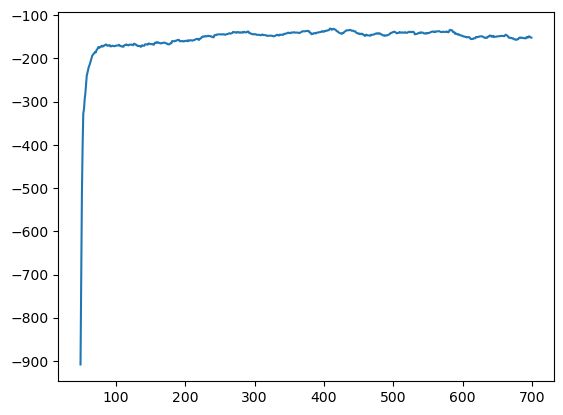

In [30]:
df = pd.DataFrame(data=total_rewards,columns=["reward"])
df["running_mean"] = df["reward"].rolling(window=50).mean()
plt.plot(df.running_mean)
plt.show()

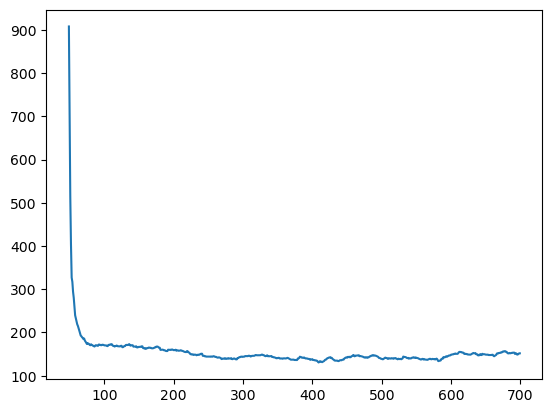

In [31]:
df = pd.DataFrame(data=total_iterations,columns=["iteration"])
df["running_mean"] = df["iteration"].rolling(window=50).mean()
plt.plot(df.running_mean)
plt.show()

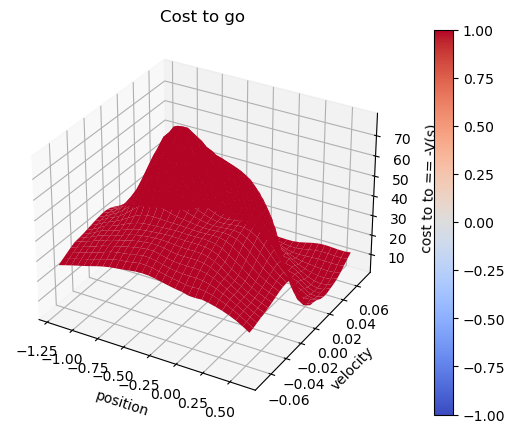

In [32]:
plot_cost_to_go_function(environment,q_model)

We can see that it converges faster than the RBF one-step, let's try the same experiment but using more steps(5)

In [33]:
EPISODES = 700
PRINT_EVERY = 10

environment = gym.make("MountainCar-v0",render_mode="rgb_array")
rbf_sampler = FeatureTransformer(environment,10000,500)
q_model = QModel(environment,rbf_sampler,"constant")

gamma  = 0.99 # disccount factor
epsilon_decay = 0.97 #
epsilon = 1.0 # start fully exploring

total_rewards10 = []
total_iterations10 = []

for episode_num in range(EPISODES):
    total_reward,iterations = run_episode(environment,q_model,epsilon,gamma,n=10)
    total_rewards10.append(total_reward)
    total_iterations10.append(iterations)
    

    if episode_num % PRINT_EVERY == 0:
        print(f"Episode {episode_num}, epsilon:{epsilon}, total_reward {total_reward}, {iterations} iterations")
    epsilon = epsilon*epsilon_decay if epsilon > 0.05 else 0.05
print(f"Mean reward for last 100 episodes:{np.array(total_rewards10[-100:]).mean()}")

Episode 0, epsilon:1.0, total_reward -10000.0, 10000 iterations
Episode 10, epsilon:0.7374241268949281, total_reward -677.0, 677 iterations
Episode 20, epsilon:0.5437943429267471, total_reward -300.0, 300 iterations
Episode 30, epsilon:0.4010070685431576, total_reward -434.0, 434 iterations
Episode 40, epsilon:0.2957122873991326, total_reward -10000.0, 10000 iterations
Episode 50, epsilon:0.21806537534740741, total_reward -423.0, 423 iterations
Episode 60, epsilon:0.1608066690215767, total_reward -317.0, 317 iterations
Episode 70, epsilon:0.11858271750211788, total_reward -240.0, 240 iterations
Episode 80, epsilon:0.08744575691882718, total_reward -143.0, 143 iterations
Episode 90, epsilon:0.06448461094653227, total_reward -140.0, 140 iterations
Episode 100, epsilon:0.05, total_reward -164.0, 164 iterations
Episode 110, epsilon:0.05, total_reward -244.0, 244 iterations
Episode 120, epsilon:0.05, total_reward -138.0, 138 iterations
Episode 130, epsilon:0.05, total_reward -144.0, 144 ite

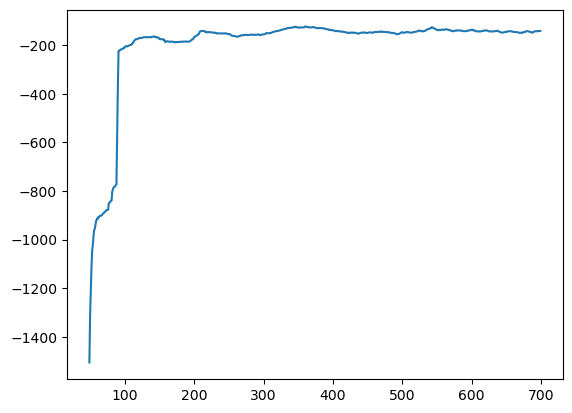

In [34]:
df = pd.DataFrame(data=total_rewards10,columns=["reward"])
df["running_mean"] = df["reward"].rolling(window=50).mean()
plt.plot(df.running_mean)
plt.show()

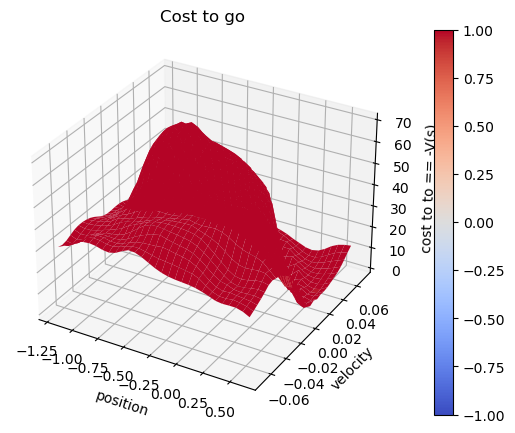

In [35]:
plot_cost_to_go_function(environment,q_model)

The cost to go functions look similar, now compare the reward plots side by side

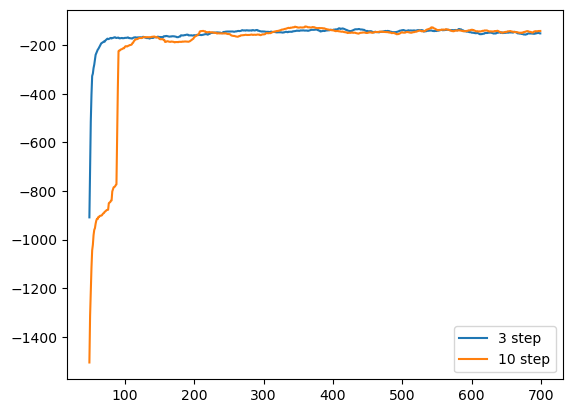

In [37]:
df3 = pd.DataFrame(data=total_rewards,columns=["reward"])
df3["running_mean3"] = df3["reward"].rolling(window=50).mean()
plt.plot(df3.running_mean3,label="3 step")
df = pd.DataFrame(data=total_rewards10,columns=["reward"])
df["running_mean10"] = df["reward"].rolling(window=50).mean()
plt.plot(df.running_mean10,label="10 step")
plt.legend()
plt.show()

It seems like there is not a huge difference between using 3 and 10 steps, however there is a big difference between 1 step(from other notebook), more rigourus analysis whould be performed though.

## Check a trained agent

In [39]:
environment = gym.make("MountainCar-v0",render_mode="rgb_array")

state,_ = environment.reset()
done = False
total_reward = 0 
iterations = 0
epsilon = 0.0
renders = [] # will store the environment frames to create a gif later

while not done and iterations<=10000:
    action = q_model.select_action(state,epsilon)
    new_state, reward, done, trunc, info = environment.step(action)
    total_reward += reward
    frame = environment.render()
    renders.append(frame)
    
    if iterations % 1000 == 0:
        print(f"iteration {iterations} with total reward {total_reward}")
        
    state = new_state
    iterations += 1

print(f"Total reward {total_reward} in {iterations} iterations")

iteration 0 with total reward -1.0
Total reward -87.0 in 87 iterations


In [40]:
imgs = [Image.fromarray(img) for img in renders]
imgs[0].save("../animations/QLearningNStepTrained.gif",save_all=True, append_images=imgs[1:],loop=0)

<img src="../animations/QLearningNStepTrained.gif" width="750" align="center" loop=False>